In [1]:
# Snippets copied liberally from https://blog.keras.io/building-autoencoders-in-keras.html

## Load and preprocess mnist digits dataset

For simplicity, we treat 28x28 grayscale images as 784-dimensional vectors. 

We also divide by 255 to make brightnesses be in range [0, 1].

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

2024-01-05 23:29:05.929289: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 23:29:06.110780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 23:29:06.110908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 23:29:06.148116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 23:29:06.229180: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 23:29:06.230388: I tensorflow/core/platform/cpu_feature_guard.cc:1

(60000, 784)
(10000, 784)


## Fit an autoencoder with 32-dimensional bottleneck layer

In [3]:
import keras
from keras import layers

def make_dense_autoencoder(encoding_dim):
    input_img = keras.Input(shape=(784,))
    encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
    decoded = layers.Dense(784, activation='sigmoid')(encoded)
    
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [4]:
autoencoder = make_dense_autoencoder(encoding_dim=32)

autoencoder.fit(
    x=x_train, y=x_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

2024-01-05 23:29:08.756566: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-01-05 23:29:08.973444: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20
235/235 [==============================] - 2s 7ms/step - loss: 0.2763 - val_loss: 0.1884
Epoch 2/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1705 - val_loss: 0.1524
Epoch 3/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1427 - val_loss: 0.1326
Epoch 4/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1275 - val_loss: 0.1203
Epoch 5/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1171 - val_loss: 0.1118
Epoch 6/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1097 - val_loss: 0.1055
Epoch 7/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1046 - val_loss: 0.1012
Epoch 8/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1010 - val_loss: 0.0984
Epoch 9/20
235/235 [==============================] - 1s 6ms/step - loss: 0.0985 - val_loss: 0.0961
Epoch 10/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0967 - val_loss: 0.0948

In [5]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 495us/step


In [20]:
import matplotlib.pyplot as plt

def view_images(images, savefile=None):
    # reshape and de-normalize
    images = [img.reshape(28, 28) * 255 for img in images]
    
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

    for i, img in enumerate(images):
        # img = Image.open(images[i])
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=255)
        axes[i].axis('off')

    fig.tight_layout()

    if savefile:
        fig.savefig("outputs/"+savefile, bbox_inches='tight', transparent=True, pad_inches=0)

    plt.show()


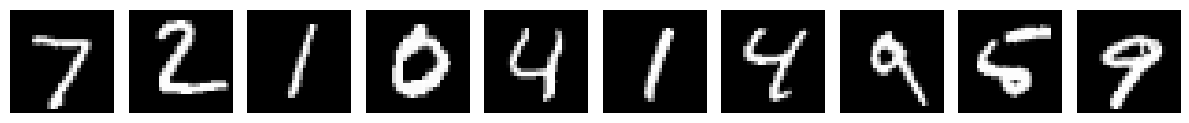

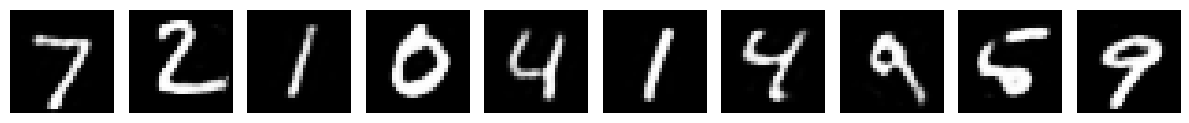

In [21]:
view_images(x_test[:10], savefile="mnist_original.png")
view_images(decoded_imgs[:10], "mnist_emb32.png")

In [8]:
mse = keras.losses.MeanSquaredError()
mse(decoded_imgs, x_test).numpy()

0.009737954

## Compare to downsampling/upsampling

Downsampling to 8x8 would use 64 floats, which is already more than our 32.  As we will see, our autoencoder has better reconstruction error.

In [9]:
from PIL import Image

def downsample_upsample(img, downsample_side):
    img = (img.reshape(28,28) * 255).astype(np.uint8)
    img = Image.fromarray(img, 'L')

    img = img.resize((downsample_side,downsample_side)).resize((28,28))

    return np.asarray(img).reshape(784,) / 255

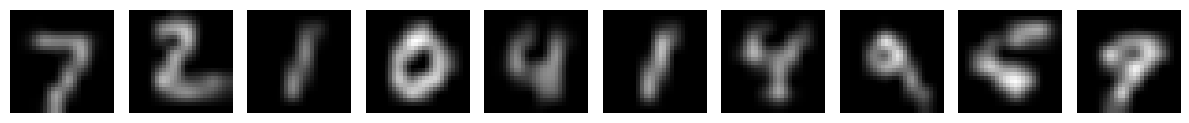

In [10]:
resampled = [downsample_upsample(img, downsample_side=8) for img in x_test]
view_images(resampled[:10], "mnist_resampled.png")

In [11]:
mse(resampled, x_test).numpy()

0.0315632

## Play with some other parameters

For fun, we can also try things like:
 - smaller (16) or bigger (64) bottleneck layer sizes.
 - look at the distribution of errors

In [12]:
autoencoder = make_dense_autoencoder(encoding_dim=16)

autoencoder.fit(
    x=x_train, y=x_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

2024-01-05 23:29:38.293186: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-01-05 23:29:38.492330: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20
235/235 [==============================] - 2s 6ms/step - loss: 0.3091 - val_loss: 0.2236
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1998 - val_loss: 0.1814
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1730 - val_loss: 0.1632
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.1589 - val_loss: 0.1527
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.1507 - val_loss: 0.1463
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1456 - val_loss: 0.1424
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1424 - val_loss: 0.1398
Epoch 8/20
235/235 [==============================] - 1s 5ms/step - loss: 0.1401 - val_loss: 0.1380
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1382 - val_loss: 0.1361
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1367 - val_loss: 0.1347

313/313 [==============================] - 0s 476us/step


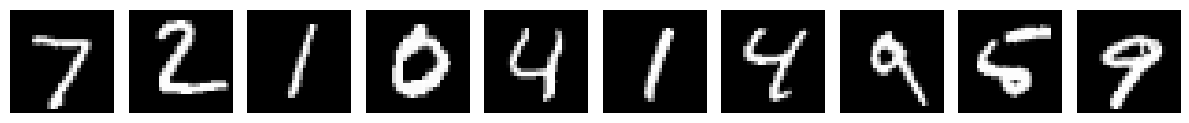

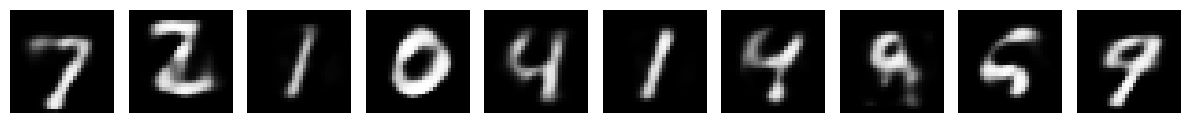

In [13]:
decoded_imgs = autoencoder.predict(x_test)
view_images(x_test[:10], savefile="mnist_original.png")
view_images(decoded_imgs[:10], "mnist_emb16.png")

In [14]:
mse = keras.losses.MeanSquaredError()
mse(decoded_imgs, x_test).numpy()

0.021541284

In [15]:
import seaborn as sns

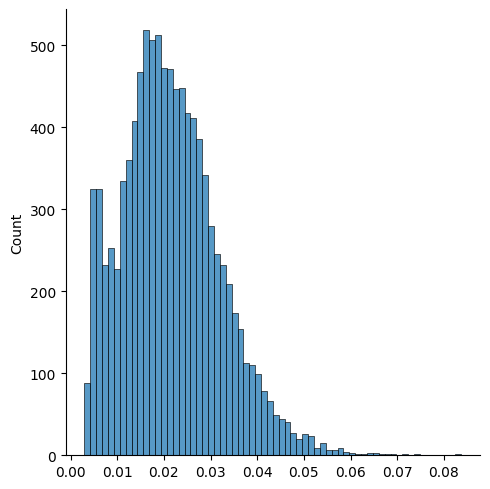

In [16]:
errors = [mse(decoded_imgs[i], x_test[i]).numpy() for i in range(len(x_test))] 
sns.displot(errors)

In [17]:
autoencoder = make_dense_autoencoder(encoding_dim=64)

autoencoder.fit(
    x=x_train, y=x_train,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

2024-01-05 23:30:06.830506: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20
235/235 [==============================] - 2s 7ms/step - loss: 0.2433 - val_loss: 0.1609
Epoch 2/20
235/235 [==============================] - 1s 6ms/step - loss: 0.1429 - val_loss: 0.1264
Epoch 3/20
235/235 [==============================] - 2s 7ms/step - loss: 0.1178 - val_loss: 0.1080
Epoch 4/20
235/235 [==============================] - 2s 7ms/step - loss: 0.1035 - val_loss: 0.0971
Epoch 5/20
235/235 [==============================] - 1s 6ms/step - loss: 0.0946 - val_loss: 0.0901
Epoch 6/20
235/235 [==============================] - 2s 6ms/step - loss: 0.0885 - val_loss: 0.0852
Epoch 7/20
235/235 [==============================] - 2s 6ms/step - loss: 0.0842 - val_loss: 0.0816
Epoch 8/20
235/235 [==============================] - 2s 6ms/step - loss: 0.0812 - val_loss: 0.0792
Epoch 9/20
235/235 [==============================] - 2s 6ms/step - loss: 0.0791 - val_loss: 0.0775
Epoch 10/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0776 - val_loss: 0.0763

313/313 [==============================] - 0s 528us/step


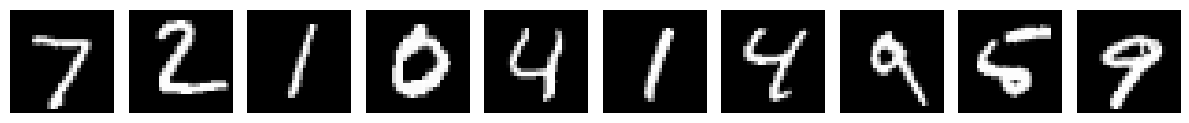

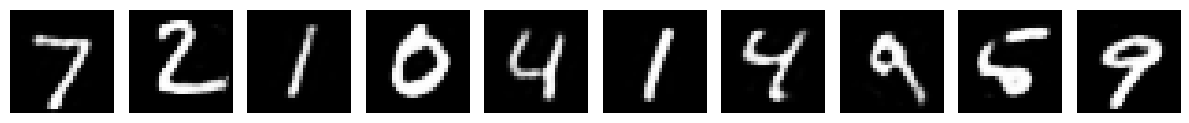

In [18]:
decoded_imgs = autoencoder.predict(x_test)
view_images(x_test[:10], savefile="mnist_original.png")
view_images(decoded_imgs[:10], "mnist_emb64.png")

In [19]:
mse = keras.losses.MeanSquaredError()
mse(decoded_imgs, x_test).numpy()

0.0039008956